In [1]:
import torch

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1+cu118
Is CUDA enabled? True


In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 2060


In [3]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast, AutoModelForPreTraining, AutoTokenizer
from torch.utils.data import Dataset

c:\Users\Shafakat Arnob\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
ROOT_DIR = '../trac2-dataset/'

df_org= pd.read_csv(ROOT_DIR + "iben/trac2_iben_train.csv")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,ID,Text,Sub-task A,Sub-task B
2447,C66.20,Tader personal Tara lead krbe eder ato matha b...,CAG,NGEN
3712,C65.235,এই সব বোকাচোদাদের জন্য আর বাংলা সিনেমা দেখা বা...,CAG,GEN
1964,C68.196,Chi....ber kore dewa uchit oke,CAG,NGEN
2554,C68.1145,Baiman Ranumandal,OAG,NGEN
1694,C44.102.1,"@S.B Studio জি না ভাই , সব মেয়ে যদি বোন হয় বউ ...",NAG,GEN


In [6]:
labels = df_org['Sub-task B'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['NGEN', 'GEN']

In [7]:
for key, value in enumerate(labels):
    print(value)

NGEN
GEN


In [8]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [9]:
label2id

{'NGEN': 0, 'GEN': 1}

In [10]:
id2label

{0: 'NGEN', 1: 'GEN'}

In [11]:
df_org.head()

,ID,Text,Sub-task A,Sub-task B
2447,C66.20,Tader personal Tara lead krbe eder ato matha b...,CAG,NGEN
3712,C65.235,এই সব বোকাচোদাদের জন্য আর বাংলা সিনেমা দেখা বা...,CAG,GEN
1964,C68.196,Chi....ber kore dewa uchit oke,CAG,NGEN
2554,C68.1145,Baiman Ranumandal,OAG,NGEN
1694,C44.102.1,"@S.B Studio জি না ভাই , সব মেয়ে যদি বোন হয় বউ ...",NAG,GEN


In [12]:
df_org["labels"]=df_org['Sub-task B'].map(lambda x: label2id[x.strip()])

In [13]:
df_org.head()

,ID,Text,Sub-task A,Sub-task B,labels
2447,C66.20,Tader personal Tara lead krbe eder ato matha b...,CAG,NGEN,0
3712,C65.235,এই সব বোকাচোদাদের জন্য আর বাংলা সিনেমা দেখা বা...,CAG,GEN,1
1964,C68.196,Chi....ber kore dewa uchit oke,CAG,NGEN,0
2554,C68.1145,Baiman Ranumandal,OAG,NGEN,0
1694,C44.102.1,"@S.B Studio জি না ভাই , সব মেয়ে যদি বোন হয় বউ ...",NAG,GEN,1


<Axes: ylabel='count'>

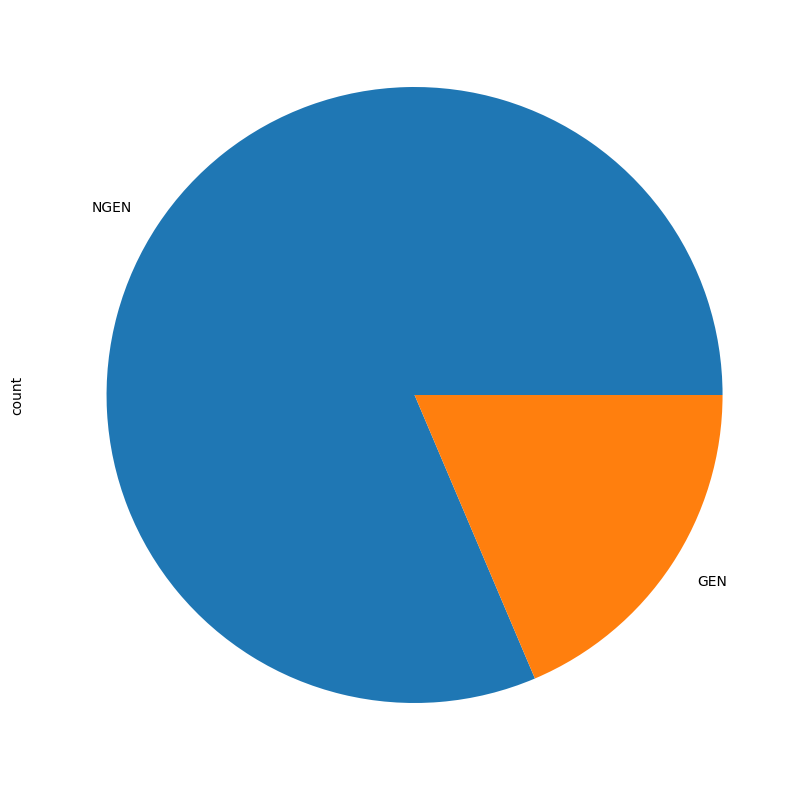

In [14]:
df_org['Sub-task B'].value_counts().plot(kind='pie', figsize=(10,10))

In [15]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [16]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
# Splitting df_org

SIZE= df_org.shape[0]

train_texts= list(df_org.Text[:SIZE//2])

val_texts=   list(df_org.Text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.Text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [18]:
len(train_texts)

1913

In [19]:
len(train_texts), len(val_texts), len(test_texts)

(1913, 956, 957)

In [20]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [21]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [22]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [23]:
# Training with Trainer Class
from transformers import TrainingArguments, Trainer

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [25]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./iben-bert-base-uncased-results',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./iben-bert-base-uncased-logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [26]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [27]:
torch.cuda.empty_cache()

In [28]:
trainer.train()

  2%|▏         | 10/480 [00:49<39:53,  5.09s/it]

{'loss': 0.6352, 'learning_rate': 5e-06, 'epoch': 0.04}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
  2%|▏         | 10/480 [02:19<39:53,  5.09s/it]

{'eval_loss': 0.5543864369392395, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 89.9936, 'eval_samples_per_second': 10.623, 'eval_steps_per_second': 0.667, 'epoch': 0.04}


  4%|▍         | 20/480 [03:08<45:56,  5.99s/it]  

{'loss': 0.523, 'learning_rate': 1e-05, 'epoch': 0.08}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
  4%|▍         | 20/480 [04:37<45:56,  5.99s/it]

{'eval_loss': 0.520132303237915, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.814, 'eval_samples_per_second': 10.764, 'eval_steps_per_second': 0.676, 'epoch': 0.08}


  6%|▋         | 30/480 [05:26<44:49,  5.98s/it]  

{'loss': 0.486, 'learning_rate': 1.5e-05, 'epoch': 0.12}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
  6%|▋         | 30/480 [06:54<44:49,  5.98s/it]

{'eval_loss': 0.5013970136642456, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.898, 'eval_samples_per_second': 10.754, 'eval_steps_per_second': 0.675, 'epoch': 0.12}


  8%|▊         | 40/480 [07:43<43:48,  5.97s/it]  

{'loss': 0.5792, 'learning_rate': 2e-05, 'epoch': 0.17}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
  8%|▊         | 40/480 [09:12<43:48,  5.97s/it]

{'eval_loss': 0.4973205327987671, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.6934, 'eval_samples_per_second': 10.779, 'eval_steps_per_second': 0.676, 'epoch': 0.17}


 10%|█         | 50/480 [09:59<41:36,  5.81s/it]  

{'loss': 0.4572, 'learning_rate': 2.5e-05, 'epoch': 0.21}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 10%|█         | 50/480 [11:28<41:36,  5.81s/it]

{'eval_loss': 0.4944641590118408, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.828, 'eval_samples_per_second': 10.762, 'eval_steps_per_second': 0.675, 'epoch': 0.21}


 12%|█▎        | 60/480 [12:15<40:39,  5.81s/it]  

{'loss': 0.4429, 'learning_rate': 3e-05, 'epoch': 0.25}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 12%|█▎        | 60/480 [13:43<40:39,  5.81s/it]

{'eval_loss': 0.5035107731819153, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.831, 'eval_samples_per_second': 10.762, 'eval_steps_per_second': 0.675, 'epoch': 0.25}


 15%|█▍        | 70/480 [14:31<40:21,  5.91s/it]  

{'loss': 0.4278, 'learning_rate': 3.5e-05, 'epoch': 0.29}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 15%|█▍        | 70/480 [16:01<40:21,  5.91s/it]

{'eval_loss': 0.546245813369751, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 90.516, 'eval_samples_per_second': 10.562, 'eval_steps_per_second': 0.663, 'epoch': 0.29}


 17%|█▋        | 80/480 [16:49<39:09,  5.87s/it]  

{'loss': 0.6365, 'learning_rate': 4e-05, 'epoch': 0.33}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 17%|█▋        | 80/480 [18:18<39:09,  5.87s/it]

{'eval_loss': 0.5070579051971436, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.84, 'eval_samples_per_second': 10.761, 'eval_steps_per_second': 0.675, 'epoch': 0.33}


 19%|█▉        | 90/480 [19:05<37:44,  5.81s/it]  

{'loss': 0.4971, 'learning_rate': 4.5e-05, 'epoch': 0.38}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 19%|█▉        | 90/480 [20:34<37:44,  5.81s/it]

{'eval_loss': 0.4888770878314972, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.8, 'eval_samples_per_second': 10.766, 'eval_steps_per_second': 0.676, 'epoch': 0.38}


 21%|██        | 100/480 [21:21<36:44,  5.80s/it] 

{'loss': 0.3785, 'learning_rate': 5e-05, 'epoch': 0.42}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 21%|██        | 100/480 [22:49<36:44,  5.80s/it]

{'eval_loss': 0.5285364389419556, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.708, 'eval_samples_per_second': 10.777, 'eval_steps_per_second': 0.676, 'epoch': 0.42}


 23%|██▎       | 110/480 [23:36<35:47,  5.80s/it]  

{'loss': 0.5279, 'learning_rate': 4.868421052631579e-05, 'epoch': 0.46}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 23%|██▎       | 110/480 [25:05<35:47,  5.80s/it]

{'eval_loss': 0.49092844128608704, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.8702, 'eval_samples_per_second': 10.757, 'eval_steps_per_second': 0.675, 'epoch': 0.46}


 25%|██▌       | 120/480 [25:52<34:53,  5.82s/it]  

{'loss': 0.5969, 'learning_rate': 4.736842105263158e-05, 'epoch': 0.5}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 25%|██▌       | 120/480 [27:21<34:53,  5.82s/it]

{'eval_loss': 0.49702176451683044, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.721, 'eval_samples_per_second': 10.775, 'eval_steps_per_second': 0.676, 'epoch': 0.5}


 27%|██▋       | 130/480 [28:08<33:51,  5.80s/it]  

{'loss': 0.5604, 'learning_rate': 4.605263157894737e-05, 'epoch': 0.54}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 27%|██▋       | 130/480 [29:37<33:51,  5.80s/it]

{'eval_loss': 0.47268804907798767, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.877, 'eval_samples_per_second': 10.756, 'eval_steps_per_second': 0.675, 'epoch': 0.54}


 29%|██▉       | 140/480 [30:24<32:56,  5.81s/it]  

{'loss': 0.4578, 'learning_rate': 4.473684210526316e-05, 'epoch': 0.58}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 29%|██▉       | 140/480 [31:53<32:56,  5.81s/it]

{'eval_loss': 0.4936296343803406, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.7629, 'eval_samples_per_second': 10.77, 'eval_steps_per_second': 0.676, 'epoch': 0.58}


 31%|███▏      | 150/480 [32:40<31:59,  5.82s/it]  

{'loss': 0.5294, 'learning_rate': 4.342105263157895e-05, 'epoch': 0.62}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 31%|███▏      | 150/480 [34:09<31:59,  5.82s/it]

{'eval_loss': 0.48072999715805054, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.7858, 'eval_samples_per_second': 10.767, 'eval_steps_per_second': 0.676, 'epoch': 0.62}


 33%|███▎      | 160/480 [34:56<30:56,  5.80s/it]  

{'loss': 0.5429, 'learning_rate': 4.210526315789474e-05, 'epoch': 0.67}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 33%|███▎      | 160/480 [36:25<30:56,  5.80s/it]

{'eval_loss': 0.5106008648872375, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.727, 'eval_samples_per_second': 10.775, 'eval_steps_per_second': 0.676, 'epoch': 0.67}


 35%|███▌      | 170/480 [37:12<30:01,  5.81s/it]  

{'loss': 0.3805, 'learning_rate': 4.078947368421053e-05, 'epoch': 0.71}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 35%|███▌      | 170/480 [38:40<30:01,  5.81s/it]

{'eval_loss': 0.462843656539917, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.793, 'eval_samples_per_second': 10.767, 'eval_steps_per_second': 0.676, 'epoch': 0.71}


 38%|███▊      | 180/480 [39:27<29:02,  5.81s/it]  

{'loss': 0.4618, 'learning_rate': 3.9473684210526316e-05, 'epoch': 0.75}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 38%|███▊      | 180/480 [40:56<29:02,  5.81s/it]

{'eval_loss': 0.45558056235313416, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 88.7839, 'eval_samples_per_second': 10.768, 'eval_steps_per_second': 0.676, 'epoch': 0.75}


 40%|███▉      | 190/480 [41:43<28:03,  5.80s/it]  

{'loss': 0.4477, 'learning_rate': 3.815789473684211e-05, 'epoch': 0.79}


C:\Users\Shafakat Arnob\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 40%|███▉      | 190/480 [43:14<28:03,  5.80s/it]

{'eval_loss': 0.43270787596702576, 'eval_Accuracy': 0.801255230125523, 'eval_F1': 0.4448315911730546, 'eval_Precision': 0.4006276150627615, 'eval_Recall': 0.5, 'eval_runtime': 90.701, 'eval_samples_per_second': 10.54, 'eval_steps_per_second': 0.662, 'epoch': 0.79}


 42%|████▏     | 200/480 [44:01<27:13,  5.83s/it]  

{'loss': 0.4626, 'learning_rate': 3.6842105263157895e-05, 'epoch': 0.83}


                                                 
 42%|████▏     | 200/480 [45:30<27:13,  5.83s/it]

{'eval_loss': 0.4126451909542084, 'eval_Accuracy': 0.8357740585774058, 'eval_F1': 0.601504857333259, 'eval_Precision': 0.9149512459371614, 'eval_Recall': 0.5868421052631579, 'eval_runtime': 89.095, 'eval_samples_per_second': 10.73, 'eval_steps_per_second': 0.673, 'epoch': 0.83}


 44%|████▍     | 210/480 [46:17<26:09,  5.81s/it]  

{'loss': 0.4009, 'learning_rate': 3.5526315789473684e-05, 'epoch': 0.88}


                                                 
 44%|████▍     | 210/480 [47:48<26:09,  5.81s/it]

{'eval_loss': 0.46473756432533264, 'eval_Accuracy': 0.8002092050209205, 'eval_F1': 0.6894071220200886, 'eval_Precision': 0.687614137942653, 'eval_Recall': 0.6912944894874262, 'eval_runtime': 90.836, 'eval_samples_per_second': 10.524, 'eval_steps_per_second': 0.661, 'epoch': 0.88}


 46%|████▌     | 220/480 [48:39<27:38,  6.38s/it]  

{'loss': 0.5023, 'learning_rate': 3.421052631578947e-05, 'epoch': 0.92}


                                                 
 46%|████▌     | 220/480 [50:07<27:38,  6.38s/it]

{'eval_loss': 0.5094563364982605, 'eval_Accuracy': 0.8347280334728033, 'eval_F1': 0.5973985820139666, 'eval_Precision': 0.9145021645021645, 'eval_Recall': 0.5842105263157895, 'eval_runtime': 88.5818, 'eval_samples_per_second': 10.792, 'eval_steps_per_second': 0.677, 'epoch': 0.92}


 48%|████▊     | 230/480 [50:57<25:24,  6.10s/it]  

{'loss': 0.4686, 'learning_rate': 3.289473684210527e-05, 'epoch': 0.96}


                                                 
 48%|████▊     | 230/480 [52:30<25:24,  6.10s/it]

{'eval_loss': 0.4494495689868927, 'eval_Accuracy': 0.8253138075313807, 'eval_F1': 0.5588346638591604, 'eval_Precision': 0.9105037513397642, 'eval_Recall': 0.5605263157894737, 'eval_runtime': 93.3191, 'eval_samples_per_second': 10.244, 'eval_steps_per_second': 0.643, 'epoch': 0.96}


 50%|█████     | 240/480 [53:13<18:26,  4.61s/it]  

{'loss': 0.3876, 'learning_rate': 3.157894736842105e-05, 'epoch': 1.0}


                                                 
 50%|█████     | 240/480 [54:44<18:26,  4.61s/it]

{'eval_loss': 0.40753161907196045, 'eval_Accuracy': 0.8378661087866108, 'eval_F1': 0.612596243088145, 'eval_Precision': 0.9026997617857249, 'eval_Recall': 0.5940841005909029, 'eval_runtime': 90.8031, 'eval_samples_per_second': 10.528, 'eval_steps_per_second': 0.661, 'epoch': 1.0}


 52%|█████▏    | 250/480 [55:34<23:42,  6.19s/it]  

{'loss': 0.4508, 'learning_rate': 3.0263157894736844e-05, 'epoch': 1.04}


                                                 
 52%|█████▏    | 250/480 [57:09<23:42,  6.19s/it]

{'eval_loss': 0.380133718252182, 'eval_Accuracy': 0.8430962343096234, 'eval_F1': 0.6347911127410532, 'eval_Precision': 0.8961323763955343, 'eval_Recall': 0.609220832760753, 'eval_runtime': 94.5229, 'eval_samples_per_second': 10.114, 'eval_steps_per_second': 0.635, 'epoch': 1.04}


 54%|█████▍    | 260/480 [57:58<22:21,  6.10s/it]  

{'loss': 0.2589, 'learning_rate': 2.8947368421052634e-05, 'epoch': 1.08}


                                                 
 54%|█████▍    | 260/480 [59:32<22:21,  6.10s/it]

{'eval_loss': 0.396987646818161, 'eval_Accuracy': 0.850418410041841, 'eval_F1': 0.662921292905981, 'eval_Precision': 0.8941787333625859, 'eval_Recall': 0.6296207228253401, 'eval_runtime': 93.6656, 'eval_samples_per_second': 10.207, 'eval_steps_per_second': 0.641, 'epoch': 1.08}


 56%|█████▋    | 270/480 [1:00:23<22:38,  6.47s/it]

{'loss': 0.397, 'learning_rate': 2.7631578947368426e-05, 'epoch': 1.12}


                                                   
 56%|█████▋    | 270/480 [1:01:59<22:38,  6.47s/it]

{'eval_loss': 0.3868918716907501, 'eval_Accuracy': 0.858786610878661, 'eval_F1': 0.7024121082716337, 'eval_Precision': 0.8670084860143656, 'eval_Recall': 0.6625463790023361, 'eval_runtime': 96.6397, 'eval_samples_per_second': 9.892, 'eval_steps_per_second': 0.621, 'epoch': 1.12}


 58%|█████▊    | 280/480 [1:02:52<22:28,  6.74s/it]  

{'loss': 0.2716, 'learning_rate': 2.6315789473684212e-05, 'epoch': 1.17}


                                                   
 58%|█████▊    | 280/480 [1:04:29<22:28,  6.74s/it]

{'eval_loss': 0.358288049697876, 'eval_Accuracy': 0.8598326359832636, 'eval_F1': 0.72765848888133, 'eval_Precision': 0.8245794392523365, 'eval_Recall': 0.6909028445788099, 'eval_runtime': 97.4852, 'eval_samples_per_second': 9.807, 'eval_steps_per_second': 0.615, 'epoch': 1.17}


 60%|██████    | 290/480 [1:05:23<20:47,  6.57s/it]  

{'loss': 0.3698, 'learning_rate': 2.5e-05, 'epoch': 1.21}


                                                   
 60%|██████    | 290/480 [1:07:00<20:47,  6.57s/it]

{'eval_loss': 0.36965078115463257, 'eval_Accuracy': 0.858786610878661, 'eval_F1': 0.7079872479166996, 'eval_Precision': 0.8539252053173216, 'eval_Recall': 0.6684828913013605, 'eval_runtime': 97.3201, 'eval_samples_per_second': 9.823, 'eval_steps_per_second': 0.617, 'epoch': 1.21}


 62%|██████▎   | 300/480 [1:07:50<18:20,  6.12s/it]  

{'loss': 0.4519, 'learning_rate': 2.368421052631579e-05, 'epoch': 1.25}


                                                   
 62%|██████▎   | 300/480 [1:09:22<18:20,  6.12s/it]

{'eval_loss': 0.380696177482605, 'eval_Accuracy': 0.858786610878661, 'eval_F1': 0.6965685871136869, 'eval_Precision': 0.8826704497758675, 'eval_Recall': 0.6566098667033118, 'eval_runtime': 91.6908, 'eval_samples_per_second': 10.426, 'eval_steps_per_second': 0.654, 'epoch': 1.25}


 65%|██████▍   | 310/480 [1:10:11<17:23,  6.14s/it]  

{'loss': 0.2581, 'learning_rate': 2.236842105263158e-05, 'epoch': 1.29}


                                                   
 65%|██████▍   | 310/480 [1:11:44<17:23,  6.14s/it]

{'eval_loss': 0.34869539737701416, 'eval_Accuracy': 0.8713389121338913, 'eval_F1': 0.7419091453818751, 'eval_Precision': 0.8736117050918186, 'eval_Recall': 0.6980830012367734, 'eval_runtime': 92.7825, 'eval_samples_per_second': 10.304, 'eval_steps_per_second': 0.647, 'epoch': 1.29}


 67%|██████▋   | 320/480 [1:12:32<15:52,  5.96s/it]  

{'loss': 0.3702, 'learning_rate': 2.105263157894737e-05, 'epoch': 1.33}


                                                   
 67%|██████▋   | 320/480 [1:14:10<15:52,  5.96s/it]

{'eval_loss': 0.3687342703342438, 'eval_Accuracy': 0.8692468619246861, 'eval_F1': 0.7345476759038152, 'eval_Precision': 0.8751603971094752, 'eval_Recall': 0.6908410059090284, 'eval_runtime': 97.5527, 'eval_samples_per_second': 9.8, 'eval_steps_per_second': 0.615, 'epoch': 1.33}


 69%|██████▉   | 330/480 [1:15:01<15:49,  6.33s/it]  

{'loss': 0.2422, 'learning_rate': 1.9736842105263158e-05, 'epoch': 1.38}


                                                   
 69%|██████▉   | 330/480 [1:16:43<15:49,  6.33s/it]

{'eval_loss': 0.44241344928741455, 'eval_Accuracy': 0.803347280334728, 'eval_F1': 0.7392449873777676, 'eval_Precision': 0.7193328106948341, 'eval_Recall': 0.7921945856809125, 'eval_runtime': 101.791, 'eval_samples_per_second': 9.392, 'eval_steps_per_second': 0.589, 'epoch': 1.38}


 71%|███████   | 340/480 [1:17:34<15:13,  6.52s/it]  

{'loss': 0.424, 'learning_rate': 1.8421052631578947e-05, 'epoch': 1.42}


                                                   
 71%|███████   | 340/480 [1:19:11<15:13,  6.52s/it]

{'eval_loss': 0.34473270177841187, 'eval_Accuracy': 0.8682008368200836, 'eval_F1': 0.7825452759885618, 'eval_Precision': 0.798917187738295, 'eval_Recall': 0.7693417617149925, 'eval_runtime': 96.9968, 'eval_samples_per_second': 9.856, 'eval_steps_per_second': 0.619, 'epoch': 1.42}


 73%|███████▎  | 350/480 [1:20:03<13:26,  6.21s/it]  

{'loss': 0.3171, 'learning_rate': 1.7105263157894737e-05, 'epoch': 1.46}


                                                   
 73%|███████▎  | 350/480 [1:21:37<13:26,  6.21s/it]

{'eval_loss': 0.3889044225215912, 'eval_Accuracy': 0.8692468619246861, 'eval_F1': 0.7377125461197919, 'eval_Precision': 0.867417026294986, 'eval_Recall': 0.6947986807750447, 'eval_runtime': 94.2094, 'eval_samples_per_second': 10.148, 'eval_steps_per_second': 0.637, 'epoch': 1.46}


 75%|███████▌  | 360/480 [1:22:31<12:49,  6.41s/it]  

{'loss': 0.4087, 'learning_rate': 1.5789473684210526e-05, 'epoch': 1.5}


                                                   
 75%|███████▌  | 360/480 [1:24:04<12:49,  6.41s/it]

{'eval_loss': 0.3295229375362396, 'eval_Accuracy': 0.8797071129707112, 'eval_F1': 0.7803339547280949, 'eval_Precision': 0.8478171756507482, 'eval_Recall': 0.7448605194448261, 'eval_runtime': 92.6777, 'eval_samples_per_second': 10.315, 'eval_steps_per_second': 0.647, 'epoch': 1.5}


 77%|███████▋  | 370/480 [1:24:55<11:44,  6.40s/it]  

{'loss': 0.2678, 'learning_rate': 1.4473684210526317e-05, 'epoch': 1.54}


                                                   
 77%|███████▋  | 370/480 [1:26:27<11:44,  6.40s/it]

{'eval_loss': 0.32967638969421387, 'eval_Accuracy': 0.8828451882845189, 'eval_F1': 0.7968473698989853, 'eval_Precision': 0.8367713464696224, 'eval_Recall': 0.7705647931840044, 'eval_runtime': 92.6492, 'eval_samples_per_second': 10.318, 'eval_steps_per_second': 0.648, 'epoch': 1.54}


 79%|███████▉  | 380/480 [1:27:17<10:15,  6.15s/it]  

{'loss': 0.3721, 'learning_rate': 1.3157894736842106e-05, 'epoch': 1.58}


                                                   
 79%|███████▉  | 380/480 [1:28:50<10:15,  6.15s/it]

{'eval_loss': 0.3257109224796295, 'eval_Accuracy': 0.8849372384937239, 'eval_F1': 0.7837193040187569, 'eval_Precision': 0.8728842247799593, 'eval_Recall': 0.7421877147176035, 'eval_runtime': 92.7639, 'eval_samples_per_second': 10.306, 'eval_steps_per_second': 0.647, 'epoch': 1.58}


 81%|████████▏ | 390/480 [1:29:40<09:23,  6.27s/it]

{'loss': 0.2485, 'learning_rate': 1.1842105263157895e-05, 'epoch': 1.62}


                                                   
 81%|████████▏ | 390/480 [1:31:14<09:23,  6.27s/it]

{'eval_loss': 0.3475368618965149, 'eval_Accuracy': 0.8838912133891214, 'eval_F1': 0.7846388017900089, 'eval_Precision': 0.8639762435948372, 'eval_Recall': 0.7454926480692594, 'eval_runtime': 93.5461, 'eval_samples_per_second': 10.22, 'eval_steps_per_second': 0.641, 'epoch': 1.62}


 83%|████████▎ | 400/480 [1:32:02<07:57,  5.97s/it]

{'loss': 0.3668, 'learning_rate': 1.0526315789473684e-05, 'epoch': 1.67}


                                                   
 83%|████████▎ | 400/480 [1:33:32<07:57,  5.97s/it]

{'eval_loss': 0.36205869913101196, 'eval_Accuracy': 0.8723849372384938, 'eval_F1': 0.7857100861334039, 'eval_Precision': 0.8093493226737731, 'eval_Recall': 0.7679950529064175, 'eval_runtime': 90.23, 'eval_samples_per_second': 10.595, 'eval_steps_per_second': 0.665, 'epoch': 1.67}


 85%|████████▌ | 410/480 [1:34:20<06:55,  5.94s/it]

{'loss': 0.3633, 'learning_rate': 9.210526315789474e-06, 'epoch': 1.71}


                                                   
 85%|████████▌ | 410/480 [1:35:50<06:55,  5.94s/it]

{'eval_loss': 0.35420289635658264, 'eval_Accuracy': 0.8797071129707112, 'eval_F1': 0.7938291260897858, 'eval_Precision': 0.8275117886280283, 'eval_Recall': 0.7705854060739316, 'eval_runtime': 90.0571, 'eval_samples_per_second': 10.615, 'eval_steps_per_second': 0.666, 'epoch': 1.71}


 88%|████████▊ | 420/480 [1:36:38<05:54,  5.91s/it]

{'loss': 0.2963, 'learning_rate': 7.894736842105263e-06, 'epoch': 1.75}


                                                   
 88%|████████▊ | 420/480 [1:38:08<05:54,  5.91s/it]

{'eval_loss': 0.35717064142227173, 'eval_Accuracy': 0.8786610878661087, 'eval_F1': 0.7915535739795343, 'eval_Precision': 0.8261138613861386, 'eval_Recall': 0.7679538271265631, 'eval_runtime': 90.1972, 'eval_samples_per_second': 10.599, 'eval_steps_per_second': 0.665, 'epoch': 1.75}


 90%|████████▉ | 430/480 [1:38:56<04:56,  5.93s/it]

{'loss': 0.2404, 'learning_rate': 6.578947368421053e-06, 'epoch': 1.79}


                                                   
 90%|████████▉ | 430/480 [1:40:26<04:56,  5.93s/it]

{'eval_loss': 0.3824912905693054, 'eval_Accuracy': 0.8702928870292888, 'eval_F1': 0.781217933101529, 'eval_Precision': 0.8063942307692308, 'eval_Recall': 0.7627318950116806, 'eval_runtime': 90.2389, 'eval_samples_per_second': 10.594, 'eval_steps_per_second': 0.665, 'epoch': 1.79}


 92%|█████████▏| 440/480 [1:41:14<03:56,  5.92s/it]

{'loss': 0.3645, 'learning_rate': 5.263157894736842e-06, 'epoch': 1.83}


                                                   
 92%|█████████▏| 440/480 [1:42:45<03:56,  5.92s/it]

{'eval_loss': 0.35095322132110596, 'eval_Accuracy': 0.8828451882845189, 'eval_F1': 0.7929119055539653, 'eval_Precision': 0.8427725968436155, 'eval_Recall': 0.7626494434519719, 'eval_runtime': 90.3951, 'eval_samples_per_second': 10.576, 'eval_steps_per_second': 0.664, 'epoch': 1.83}


 94%|█████████▍| 450/480 [1:43:34<02:59,  5.98s/it]

{'loss': 0.5027, 'learning_rate': 3.9473684210526315e-06, 'epoch': 1.88}


                                                   
 94%|█████████▍| 450/480 [1:45:05<02:59,  5.98s/it]

{'eval_loss': 0.3272639513015747, 'eval_Accuracy': 0.8807531380753139, 'eval_F1': 0.7912423859326514, 'eval_Precision': 0.8354691876750701, 'eval_Recall': 0.7633227978562594, 'eval_runtime': 91.7891, 'eval_samples_per_second': 10.415, 'eval_steps_per_second': 0.654, 'epoch': 1.88}


 96%|█████████▌| 460/480 [1:45:55<02:01,  6.10s/it]

{'loss': 0.2814, 'learning_rate': 2.631578947368421e-06, 'epoch': 1.92}


                                                   
 96%|█████████▌| 460/480 [1:47:28<02:01,  6.10s/it]

{'eval_loss': 0.3177909553050995, 'eval_Accuracy': 0.8828451882845189, 'eval_F1': 0.7958822632301357, 'eval_Precision': 0.8381838945219227, 'eval_Recall': 0.7685859557509963, 'eval_runtime': 93.389, 'eval_samples_per_second': 10.237, 'eval_steps_per_second': 0.642, 'epoch': 1.92}


 98%|█████████▊| 470/480 [1:48:16<01:00,  6.08s/it]

{'loss': 0.2845, 'learning_rate': 1.3157894736842106e-06, 'epoch': 1.96}


                                                   
 98%|█████████▊| 470/480 [1:49:50<01:00,  6.08s/it]

{'eval_loss': 0.3173860013484955, 'eval_Accuracy': 0.8817991631799164, 'eval_F1': 0.7945481897350168, 'eval_Precision': 0.8354148926104645, 'eval_Recall': 0.767933214236636, 'eval_runtime': 93.2947, 'eval_samples_per_second': 10.247, 'eval_steps_per_second': 0.643, 'epoch': 1.96}


100%|██████████| 480/480 [1:50:36<00:00,  4.94s/it]

{'loss': 0.2269, 'learning_rate': 0.0, 'epoch': 2.0}


                                                   
100%|██████████| 480/480 [1:52:10<00:00, 14.02s/it]

{'eval_loss': 0.3171699643135071, 'eval_Accuracy': 0.8828451882845189, 'eval_F1': 0.7958822632301357, 'eval_Precision': 0.8381838945219227, 'eval_Recall': 0.7685859557509963, 'eval_runtime': 94.7302, 'eval_samples_per_second': 10.092, 'eval_steps_per_second': 0.633, 'epoch': 2.0}
{'train_runtime': 6730.8924, 'train_samples_per_second': 0.568, 'train_steps_per_second': 0.071, 'train_loss': 0.4130429724852244, 'epoch': 2.0}


TrainOutput(global_step=480, training_loss=0.4130429724852244, metrics={'train_runtime': 6730.8924, 'train_samples_per_second': 0.568, 'train_steps_per_second': 0.071, 'train_loss': 0.4130429724852244, 'epoch': 2.0})

In [29]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

100%|██████████| 60/60 [00:42<00:00,  1.43it/s]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.222441,0.914794,0.853394,0.885316,0.829449
val,0.317170,0.882845,0.795882,0.838184,0.768586
test,0.312779,0.887147,0.767153,0.798570,0.744639


In [30]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [31]:
# Test with a an example text in Turkish
text = "Ei meyeta magi"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.0294, 0.9706]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(1, device='cuda:0'),
 'GEN')

In [32]:
model_path = "iben-bert-base-uncased-trained"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('iben-bert-base-uncased-trained\\tokenizer_config.json',
 'iben-bert-base-uncased-trained\\special_tokens_map.json',
 'iben-bert-base-uncased-trained\\vocab.txt',
 'iben-bert-base-uncased-trained\\added_tokens.json',
 'iben-bert-base-uncased-trained\\tokenizer.json')

In [33]:
model_path = "iben-bert-base-uncased-trained"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [34]:
nlp("Kala magi")

[{'label': 'GEN', 'score': 0.9666215777397156}]

In [35]:
nlp("বাস নিয়ে ভোরে দিতে হবে শালী কে")

[{'label': 'NGEN', 'score': 0.8786198496818542}]

In [36]:
nlp("fuck girls")

[{'label': 'NGEN', 'score': 0.9856134057044983}]

In [37]:
nlp("meyeta ekta bessha")

[{'label': 'NGEN', 'score': 0.9848975539207458}]

In [38]:
nlp("bessha magi")

[{'label': 'GEN', 'score': 0.9676923155784607}]